In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# (LARGE) Attentive Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 128
batch_size = 64 
num_points = 128
num_samples = 100000
n_epochs = 30


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(num_points-50, num_points-50))


def get_model(x_dim, y_dim):
    return AttentiveNeuralProcess(x_dim, y_dim,
                                  XEncoder=MLP,
                                 attention="scaledot",
                                 XYEncoder=_DeepMLP,
                                 Decoder=_DeepMLP,
                                 r_dim=r_dim,
                                 LatentEncoder=MLP,
                                 get_cntxt_trgt=get_cntxt_trgt)


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))

/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


##  Data

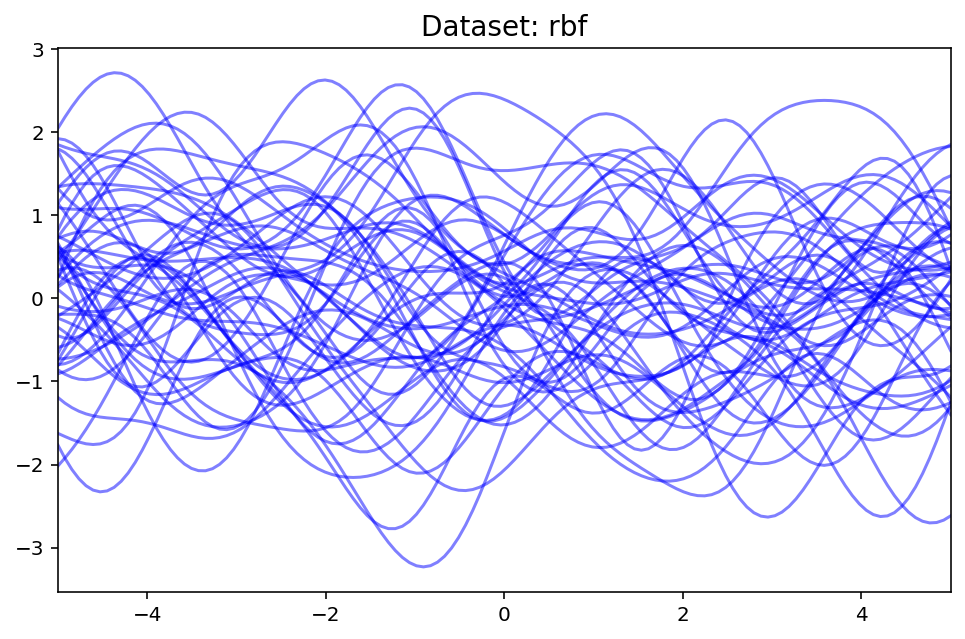

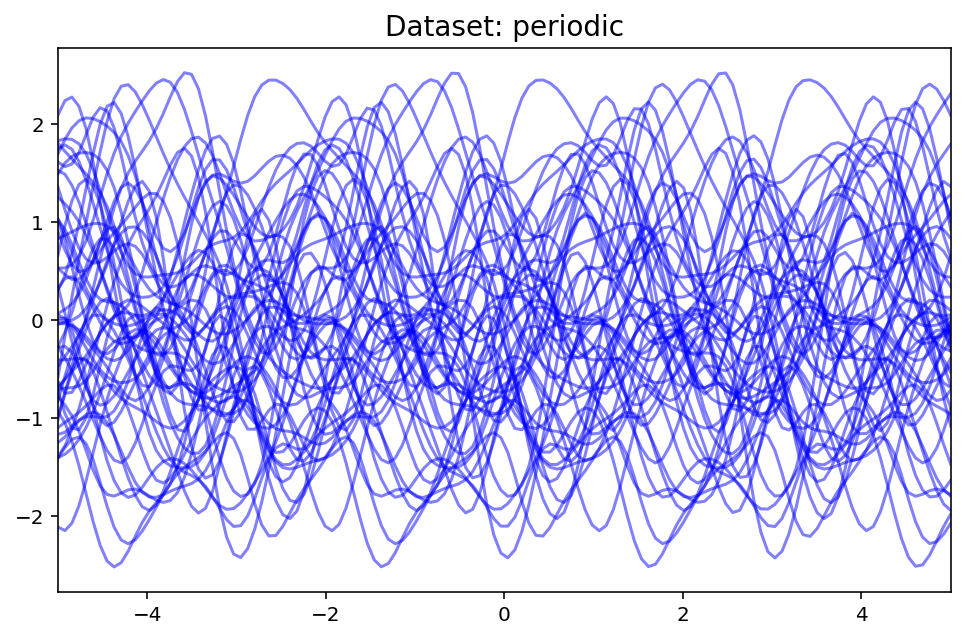

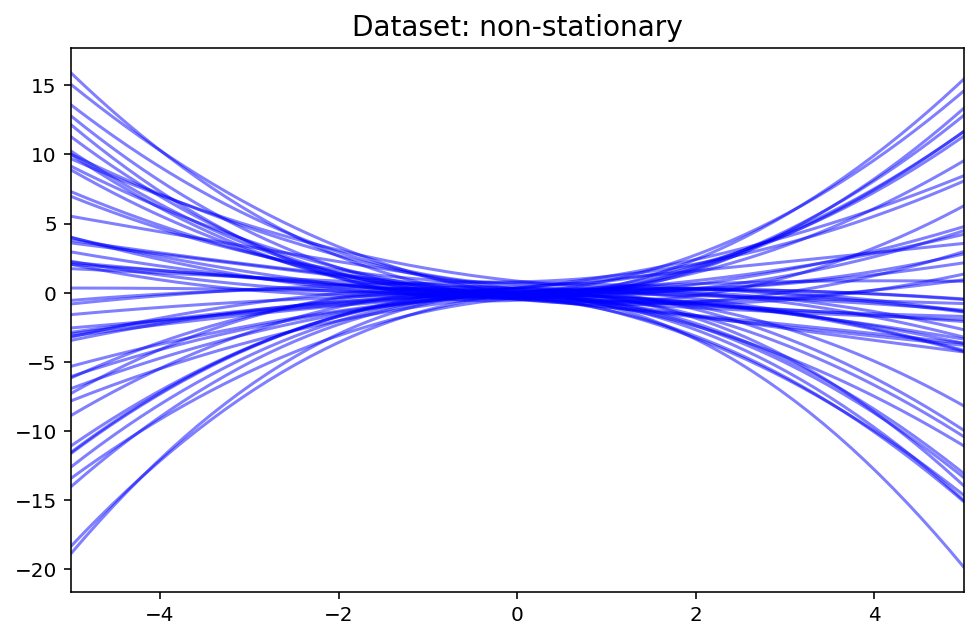

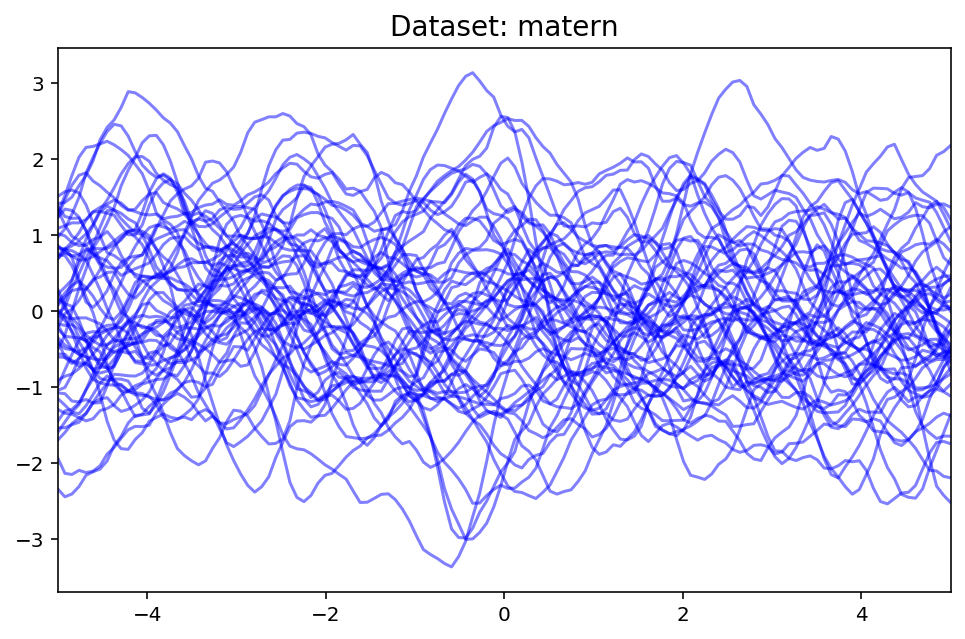

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

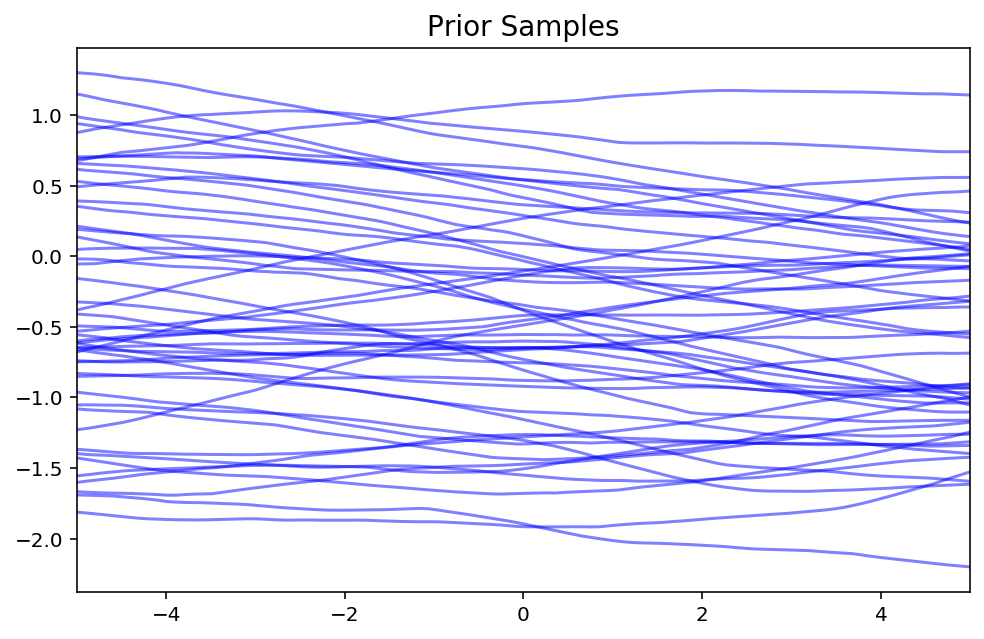

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None)  # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss      dur
-------  ------------  -------
      1      152.4865  28.1053


      2       31.9852  27.9900


      3       -4.9866  27.9655


      4      -23.0235  27.9155


      5      -24.8799  28.0195


      6      -34.7437  28.0367


      7      -41.3002  28.0365


      8      -44.0090  27.9456


      9      -56.6620  25.9412


     10      -55.1417  24.7156


     11      -66.7432  27.9855


     12      -69.6447  28.1133


     13      -57.2190  28.0494


     14      -73.1637  28.0816


     15      -78.3141  28.0395


     16      -84.9233  27.9689


     17      -69.1739  14.8455


     18      -85.5852  23.9297


     19      -86.1956  27.9433


     20      -86.3333  27.9968


     21      -85.0584  25.7039


     22      -91.2467  27.9137


     23      -94.1154  14.9530


     24      -96.7945  27.9662


     25      -96.8748  27.9230


     26      -99.2497  27.8860


     27      -96.8927  27.9290


     28     -100.1498  27.9374


     29      -98.6780  27.9352


     30     -101.0959  28.0405

--- Training periodic ---



  epoch    train_loss      dur
-------  ------------  -------
      1      659.7993  27.9705


      2      134.4918  28.0458


      3      133.0100  28.0547


      4      131.4170  28.0171


      5      130.5546  27.3777


      6      130.2761  28.0881


      7      129.4292  28.0213


      8      121.9779  27.8312


      9      117.0578  27.9444


     10      106.0159  27.9681


     11       77.3262  28.0065


     12       54.8938  27.8723


     13       43.7942  27.9281


     14       36.7953  27.9666


     15       29.6572  28.0120


     16       25.8429  28.0565


     17       21.6061  27.9267


     18       18.5517  26.6431


     19       10.5769  20.9514


     20       -7.3136  27.9676


     21      -16.9115  25.0360


     22      -26.2539  28.0262


     23      -29.5044  28.0139


     24      -35.7620  27.9952


     25      -36.1091  27.9033


     26      -41.0328  27.9971


     27      -41.1420  27.9964


     28      -42.0972  25.3526


     29      -44.9675  14.9275


     30      -49.1171  27.9175

--- Training non-stationary ---



  epoch    train_loss      dur
-------  ------------  -------
      1      296.7516  28.0123


      2      148.9956  28.0784


      3       51.2393  28.1158


      4      -37.6933  27.5708


      5      -79.4327  17.4054


      6      -95.7096  28.0469


      7     -104.3960  27.9902


      8     -111.5892  27.9549


      9     -120.9701  28.0835


     10     -123.7165  28.0102


     11     -127.7492  27.9648


     12     -132.7442  28.0816


     13     -129.6915  28.0304


     14     -132.9426  19.1677


     15     -134.8198  26.0551


     16     -135.9912  16.4672


     17     -135.7565  28.0449


     18     -135.4788  27.9419


     19     -137.9267  27.9406


     20     -138.4842  27.9295


     21     -139.6359  28.0282


     22     -137.8677  27.9851


     23     -140.7910  27.9583


     24     -146.0209  28.0216


     25     -142.0883  27.9429


     26     -144.9146  27.9617


     27     -145.9659  28.0243


     28     -139.8649  28.0064


     29     -144.6342  28.0072


     30     -146.5371  27.9538

--- Training matern ---



  epoch    train_loss      dur
-------  ------------  -------
      1      186.7657  28.0231


      2       94.2242  28.0120


      3       37.6753  28.0264


      4       24.3229  27.9922


      5       21.6058  28.0467


      6       14.3484  26.7025


      7       18.6529  20.4272


      8        9.3813  27.9188


      9        3.7103  28.0463


     10        9.3055  27.9503


     11        4.3145  27.9193


     12        0.9177  28.0314


     13        6.6646  20.8771


     14       -5.2076  27.9503


     15       -8.4968  27.9790


     16      -13.1581  28.0036


     17      -14.6077  28.0413


     18      -17.4641  28.0872


     19      -18.5390  28.1180


     20      -19.1636  28.0090


     21      -20.1541  28.0200


     22      -21.5672  27.9961


     23      -24.7334  27.8743


     24      -25.5606  28.0466


     25      -26.1173  27.9779


     26      -29.1265  15.0429


     27      -29.1408  15.1255


     28      -30.8195  16.1008


     29      -27.7090  26.9111


     30      -32.0552  23.9289


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

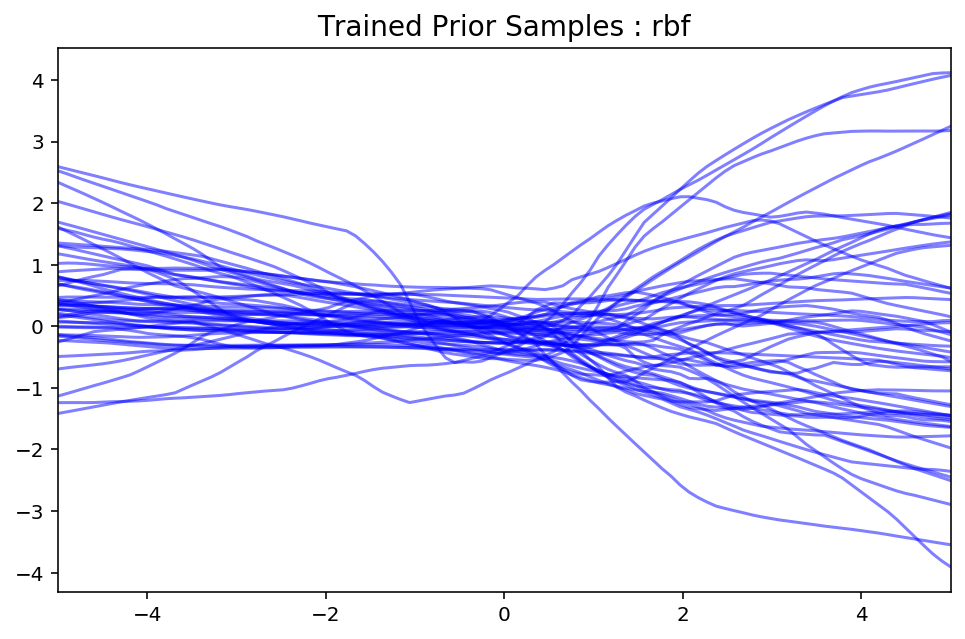

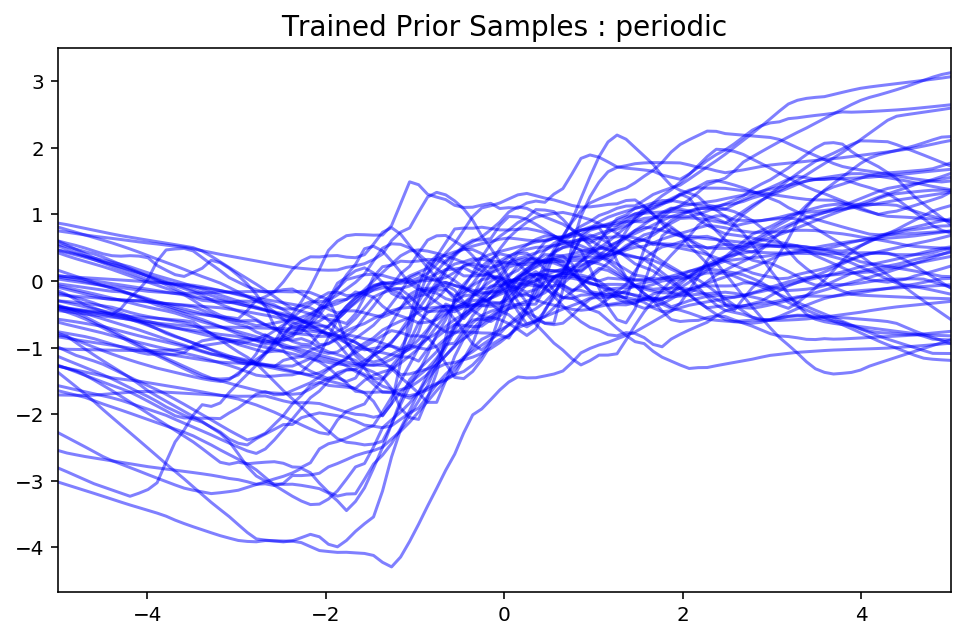

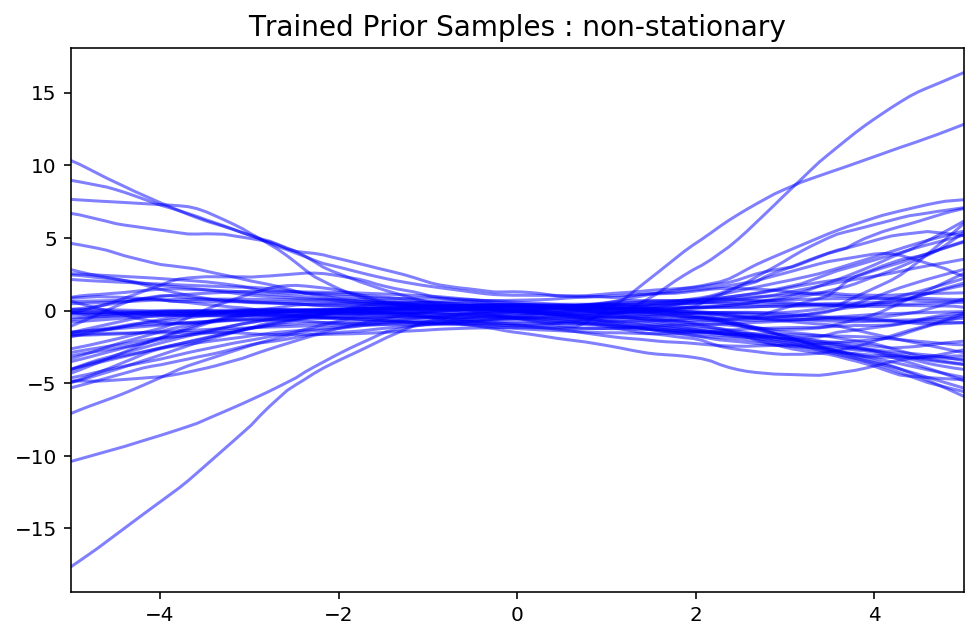

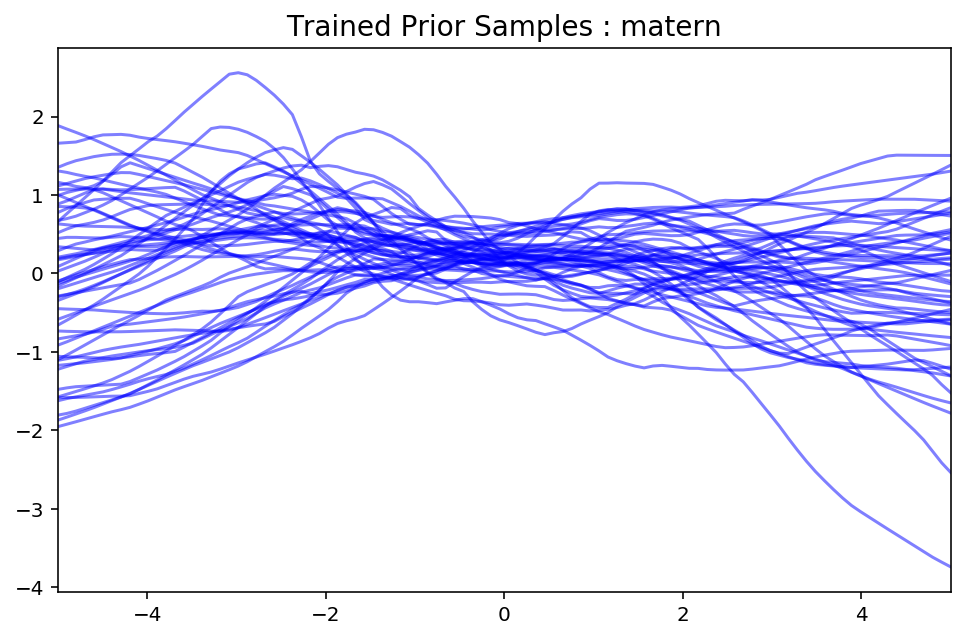

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.2260343
std: 0.19682708
std: 0.11442815
std: 0.40183336


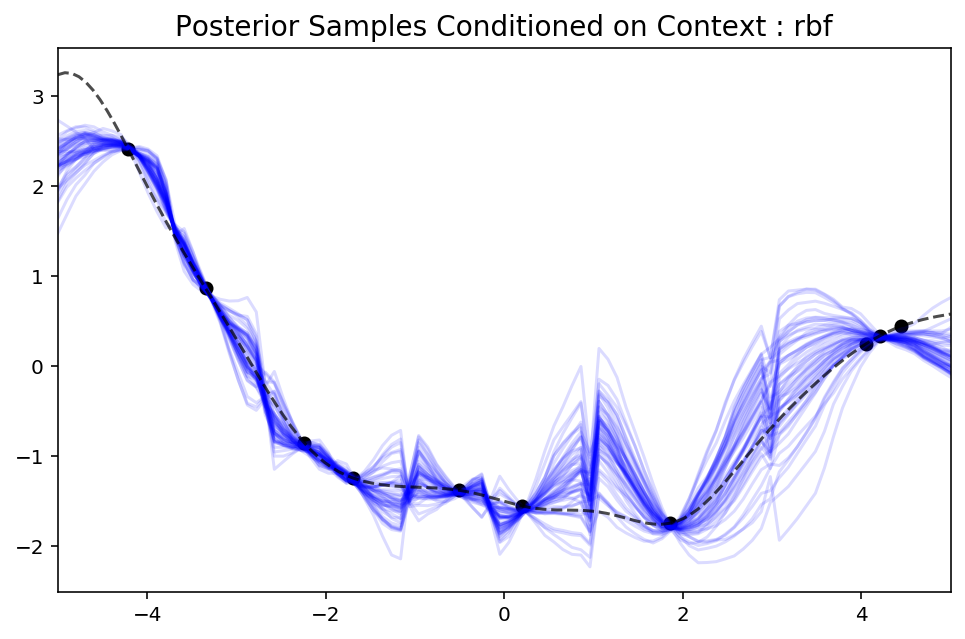

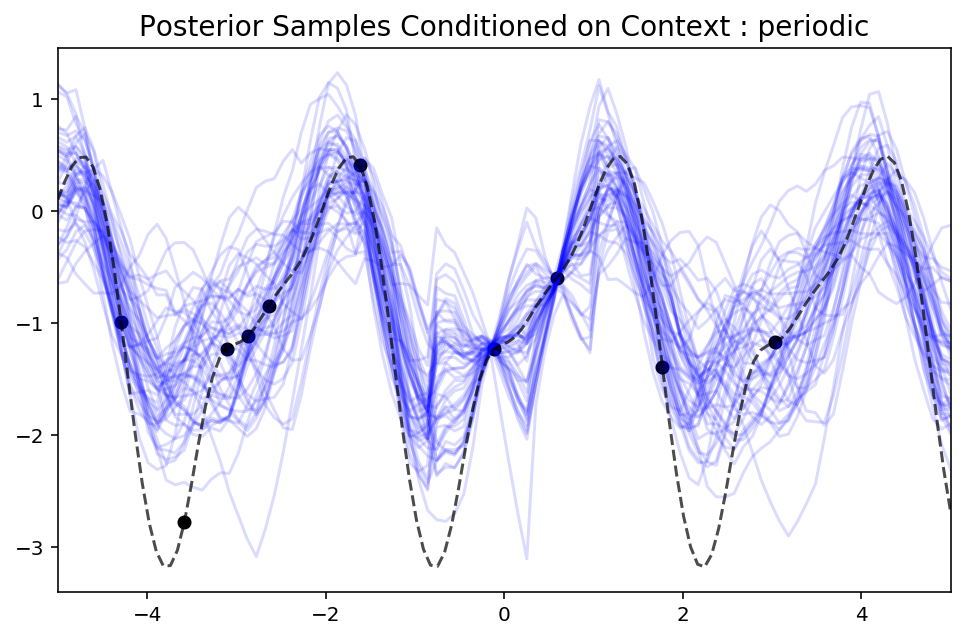

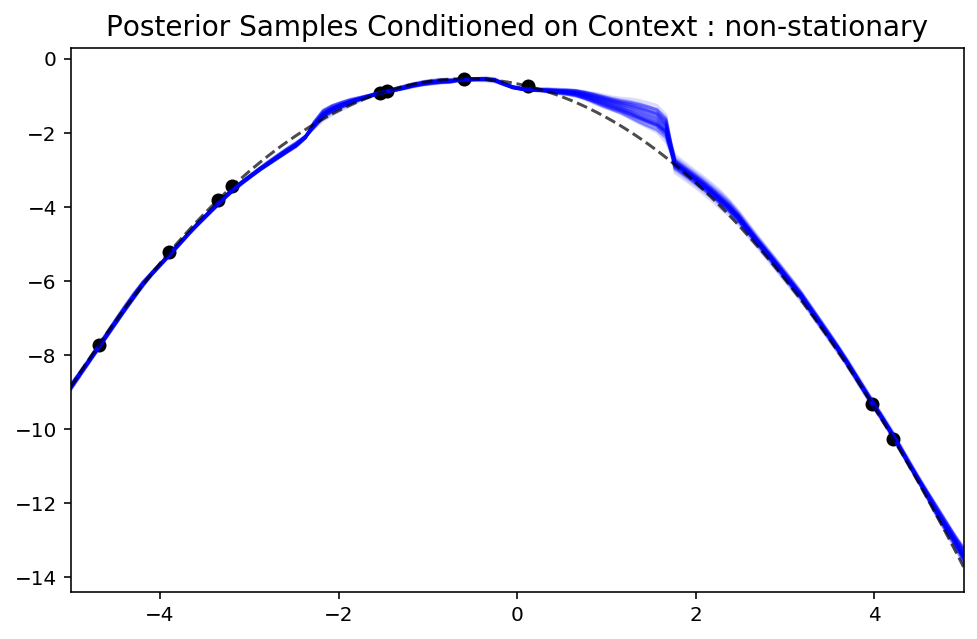

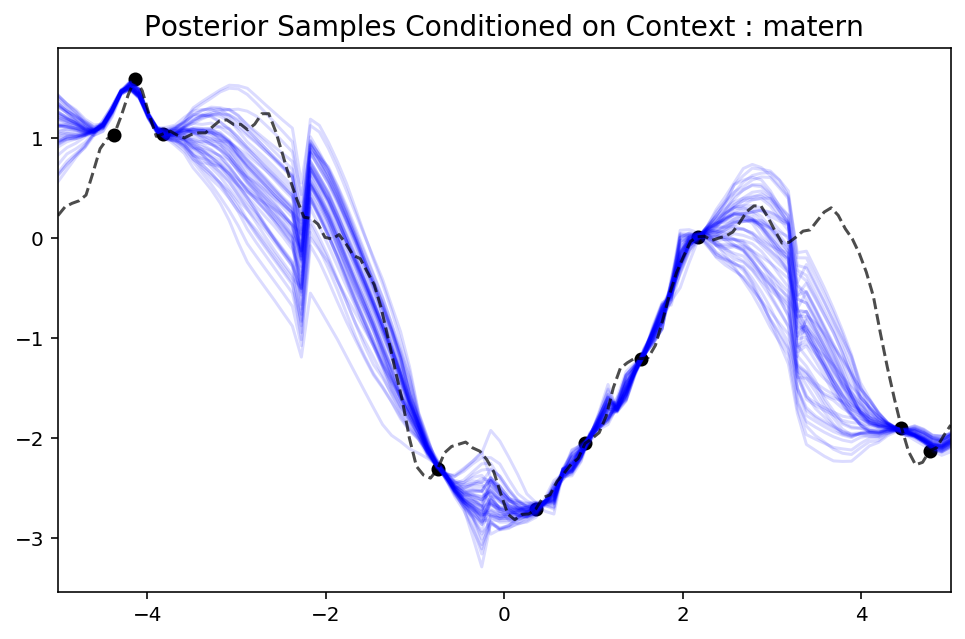

In [9]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 0.94379663
std: 0.30810702
std: 0.43860114
std: 0.5918603


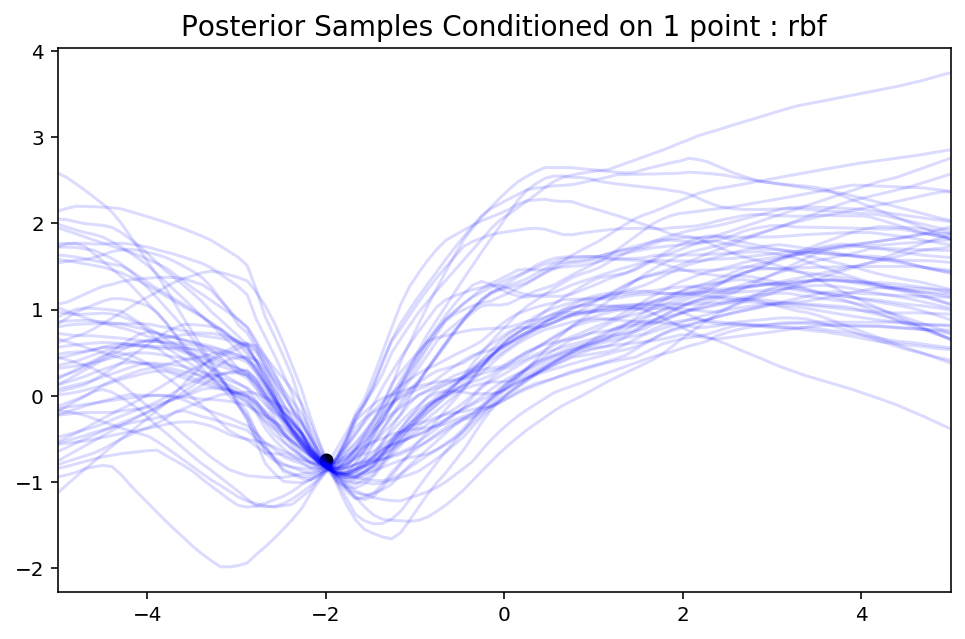

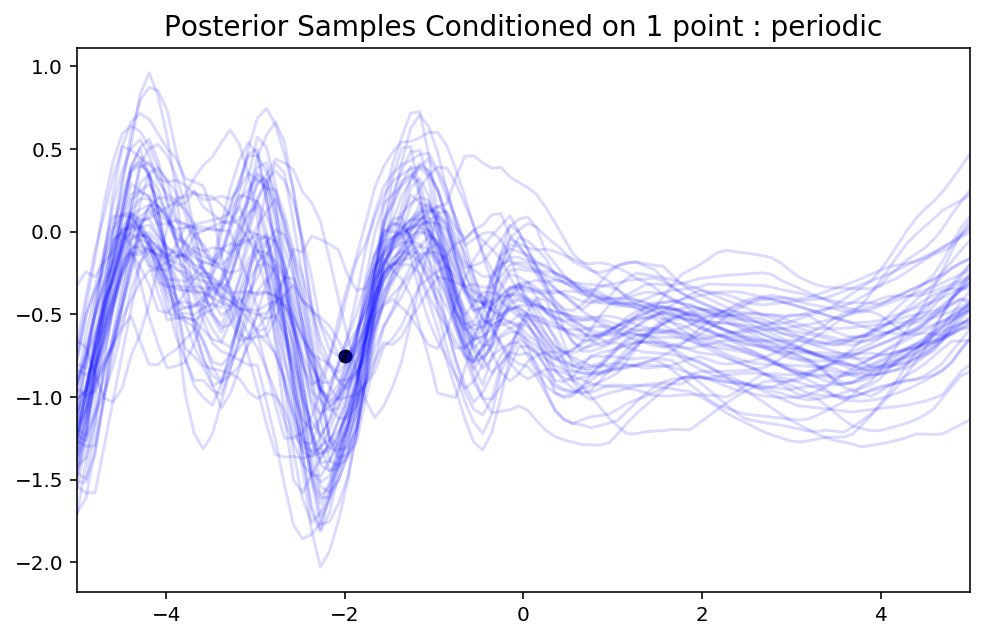

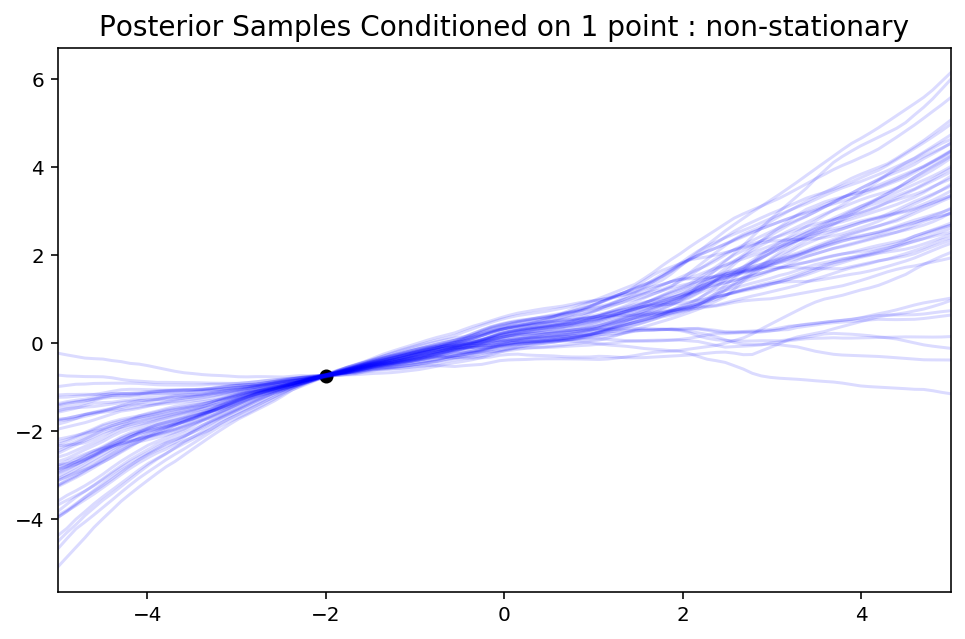

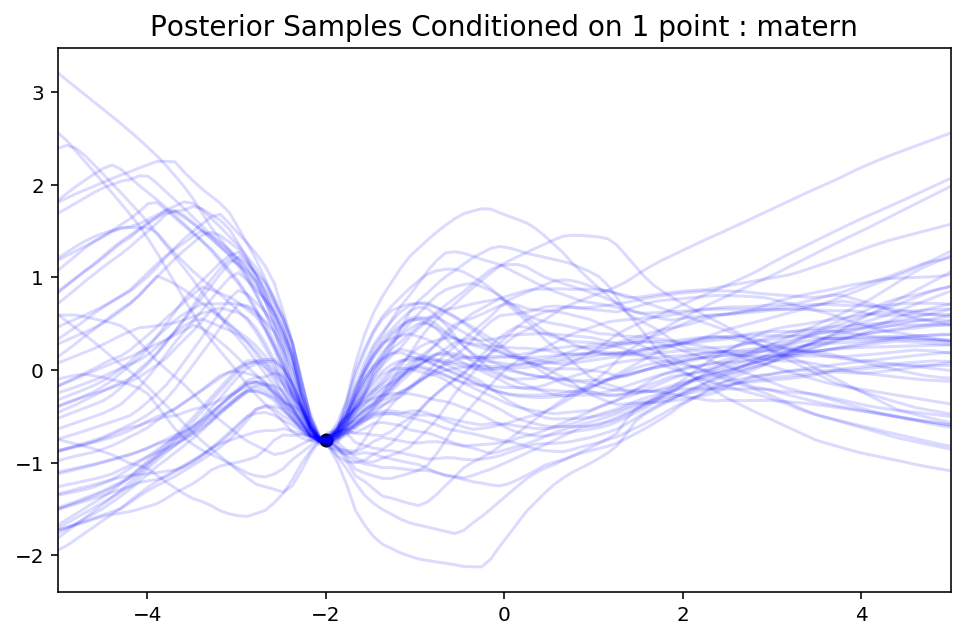

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 1.5807388
std: 0.30870882
std: 0.46439067
std: 0.5822472


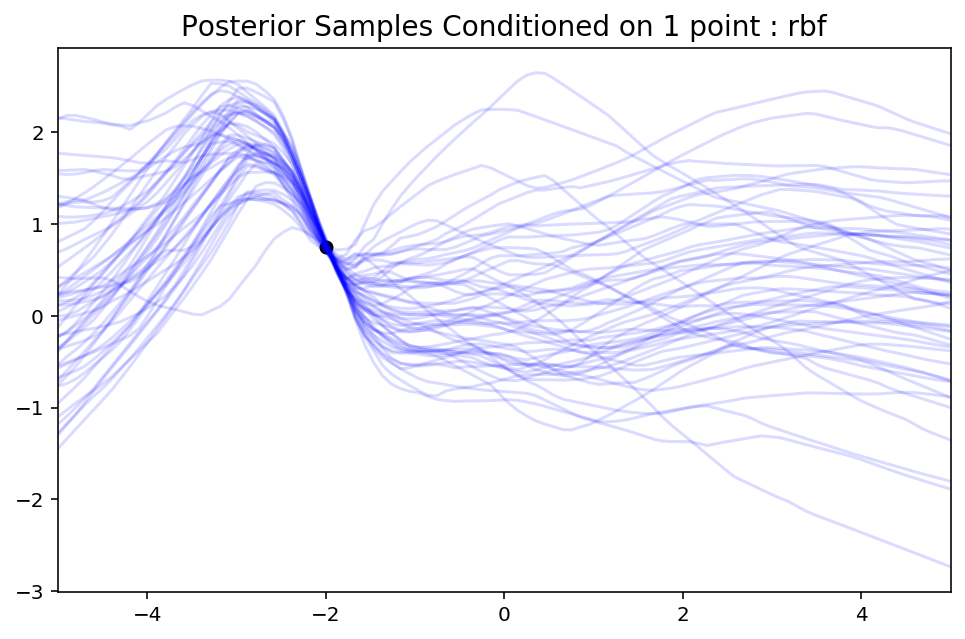

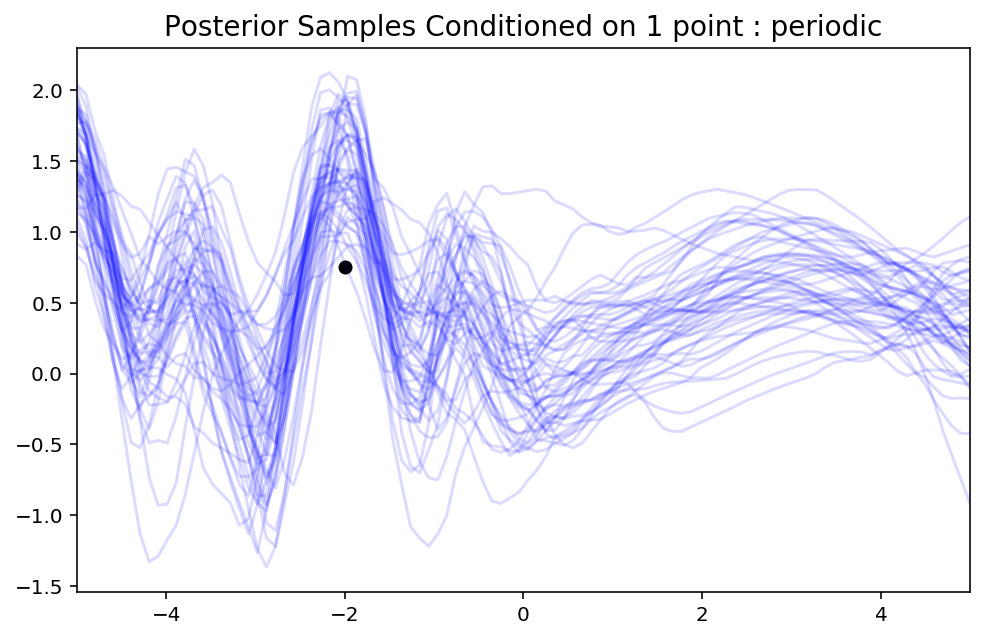

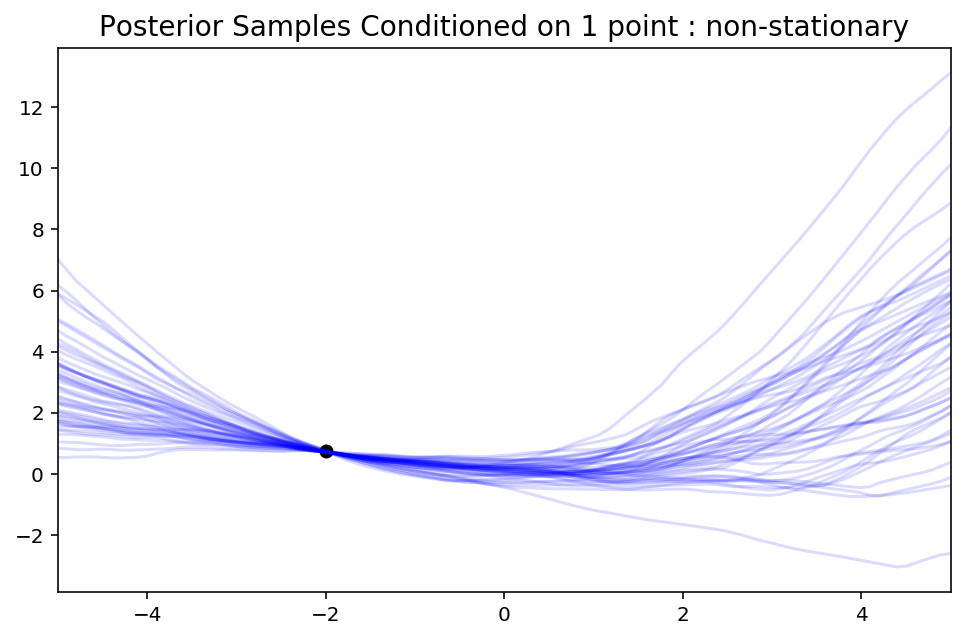

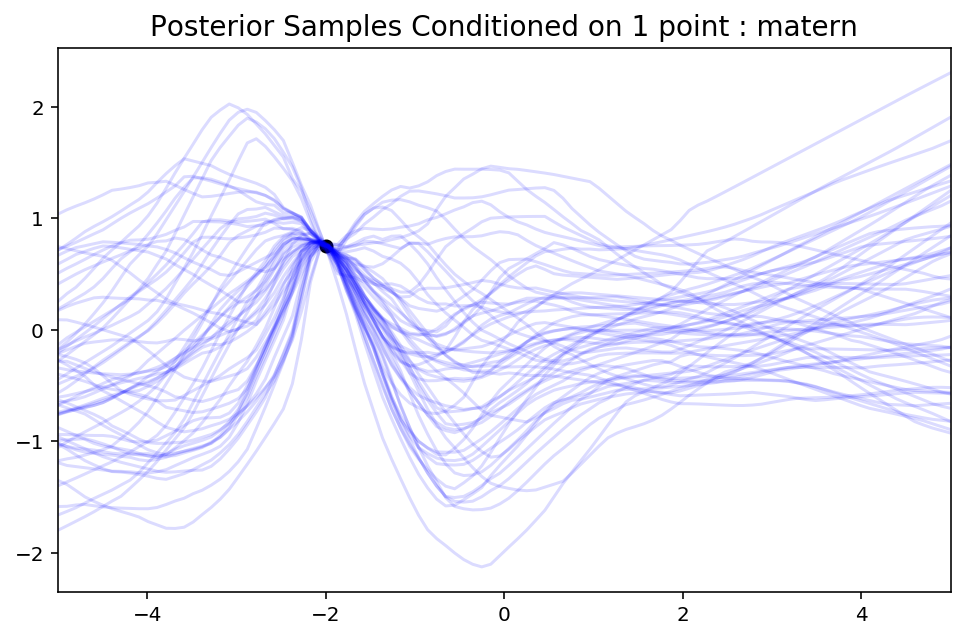

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))